# Semantic Shift Slang Processing in LLMs

## ACL 2025 Experiment - SAE Feature Analysis

This notebook analyzes how **Semantic Shift slang** (e.g., "cook", "slay", "vibe") is processed across all 48 layers in Gemma-3-12B using **Gemma Scope 2 SAEs**.

**Hypothesis:** Semantic shift slang requires inhibiting the dominant literal meaning, so it should be processed primarily in **deep layers** (>66% depth) where the model handles metaphor and complex disambiguation.

## 1. Environment Setup

In [ ]:
!pip install -q transformers accelerate torch safetensors
!pip install -q sae-lens
!pip install datasets pandas numpy matplotlib seaborn scipy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.7/273.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.6/236.6 kB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from tqdm.auto import tqdm
import json
import gc
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer
from sae_lens import SAE

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.17 GB


In [ ]:
from huggingface_hub import login
from google.colab import userdata

try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("Logged in via Colab secret")
except:
    print("Manual login:")
    login()

Logged in via Colab secret


## 2. Load Semantic Shift Dataset

In [ ]:
from google.colab import files

print("Upload genz_dataset.csv:")
uploaded = files.upload()

df = pd.read_csv('genz_dataset.csv')
print(f"\nLoaded {len(df)} sentence pairs")
print(f"Columns: {df.columns.tolist()}")
df.head()

Upload genz_dataset.csv:


Saving genz_dataset.csv to genz_dataset.csv

Loaded 1002 sentence pairs
Columns: ['normal', 'gen_z']


,normal,gen_z
0,"I'm really tired today, I think I need some rest.","I'm totally drained today, need to catch some ..."
1,"I'm really tired today, I just want to relax a...","I'm hella drained today, just wanna chill at h..."
2,I'm really excited for the concert tonight.,I'm so hype for the concert tonight.
3,"I'm really tired today, I think I need some co...","I'm so drained today, I gotta get me some caff..."
4,I'm really looking forward to the weekend.,"I'm so hyped for the weekend, can't wait to tu..."


In [ ]:
@dataclass
class SlangPair:
    """A slang sentence and its literal equivalent"""
    slang_text: str
    literal_text: str

# Create pairs from dataset
pairs = [
    SlangPair(slang_text=row['gen_z'], literal_text=row['normal'])
    for _, row in df.iterrows()
]

print(f"Created {len(pairs)} slang-literal pairs")
print(f"\nExample:")
print(f"  Literal: {pairs[0].literal_text}")
print(f"  Slang:   {pairs[0].slang_text}")

Created 1002 slang-literal pairs

Example:
  Literal: I'm really tired today, I think I need some rest.
  Slang:   I'm totally drained today, need to catch some Z's.


## 3. Load Model

In [ ]:
MODEL_ID = "google/gemma-3-12b-it"

print(f"Loading {MODEL_ID} in bfloat16...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="eager"
)
model.eval()

# Get model config - Gemma 3 uses nested config
if hasattr(model.config, 'text_config'):
    NUM_LAYERS = model.config.text_config.num_hidden_layers
    HIDDEN_SIZE = model.config.text_config.hidden_size
else:
    NUM_LAYERS = len(model.model.language_model.layers)
    HIDDEN_SIZE = model.model.language_model.layers[0].self_attn.q_proj.in_features

print(f"\nModel loaded!")
print(f"  Layers: {NUM_LAYERS}")
print(f"  Hidden size: {HIDDEN_SIZE}")
print(f"  GPU memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Loading google/gemma-3-12b-it in bfloat16...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/916 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/109k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]


Model loaded!
  Layers: 48
  Hidden size: 3840
  GPU memory used: 24.38 GB


## 4. Load Gemma Scope 2 SAEs

Using `sae-lens` to load SAEs for all 48 layers from `gemma-scope-2-12b-it-res-all`.

In [ ]:
def load_sae(layer: int, width: str = "16k", l0: str = "small") -> Optional[SAE]:
    """
    Load SAE for a specific layer using sae_lens.

    Args:
        layer: Layer index (0 to NUM_LAYERS-1)
        width: '16k' or '262k'
        l0: 'small' (~10) or 'big' (~60)
    """
    try:
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release="gemma-scope-2-12b-it-res-all",
            sae_id=f"layer_{layer}_width_{width}_l0_{l0}",
        )
        return sae.to(device)
    except Exception as e:
        print(f"Could not load SAE for layer {layer}: {e}")
        return None


def load_all_saes(num_layers: int, width: str = "262k", l0: str = "small") -> Dict[int, SAE]:
    """
    Load SAEs for all layers.
    """
    saes = {}
    print(f"Loading SAEs for {num_layers} layers...")
    print(f"  Width: {width}, L0: {l0}")

    for layer in tqdm(range(num_layers), desc="Loading SAEs"):
        sae = load_sae(layer, width, l0)
        if sae is not None:
            saes[layer] = sae

    print(f"\n✓ Loaded {len(saes)}/{num_layers} SAEs")
    if saes:
        sample_sae = saes[list(saes.keys())[0]]
        print(f"  d_in: {sample_sae.cfg.d_in}")
        print(f"  d_sae: {sample_sae.cfg.d_sae}")

    return saes


# Test loading one SAE first
print("Testing SAE loading...")
test_sae = load_sae(24, width="16k", l0="small")
if test_sae:
    print(f"✓ SAE loaded successfully!")
    print(f"  d_in: {test_sae.cfg.d_in}")
    print(f"  d_sae: {test_sae.cfg.d_sae}")

Testing SAE loading...


config.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

resid_post_all/layer_24_width_16k_l0_sma(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

✓ SAE loaded successfully!
  d_in: 3840
  d_sae: 16384


In [ ]:
# Load all SAEs (this takes a few minutes)
# Using 16k width and small L0 for efficiency
# saes = load_all_saes(NUM_LAYERS, width="262k", l0="small")

Loading SAEs for 48 layers...
  Width: 262k, L0: small


Loading SAEs:   0%|          | 0/48 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

resid_post_all/layer_0_width_262k_l0_sma(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

resid_post_all/layer_1_width_262k_l0_sma(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

resid_post_all/layer_2_width_262k_l0_sma(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

## 5. Activation & SAE Feature Extraction

In [ ]:
class ActivationCache:
    """Captures layer activations via forward hooks"""

    def __init__(self, model):
        self.model = model
        self.activations: Dict[int, torch.Tensor] = {}
        self.hooks: List = []

    def _hook(self, layer_idx: int):
        def fn(module, input, output):
            if isinstance(output, tuple):
                self.activations[layer_idx] = output[0].detach()
            else:
                self.activations[layer_idx] = output.detach()
        return fn

    def _get_layers(self):
        """Get transformer layers - Gemma 3 specific path"""
        return self.model.model.language_model.layers

    def register(self, layers: Optional[List[int]] = None):
        self.clear()
        model_layers = self._get_layers()
        layers = layers or list(range(len(model_layers)))

        for idx in layers:
            hook = model_layers[idx].register_forward_hook(self._hook(idx))
            self.hooks.append(hook)
        return self

    def clear(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []
        self.activations = {}

    def get(self) -> Dict[int, torch.Tensor]:
        return self.activations

In [ ]:
def analyze_pairs_single_layer(
    pairs: List[SlangPair],
    layer: int,
    width: str = "262k",
    l0: str = "small",
    max_pairs: Optional[int] = None
) -> pd.DataFrame:
    """Analyze all pairs for a single layer, then free SAE memory."""

    if max_pairs:
        pairs = pairs[:max_pairs]

    # Load SAE for this layer only
    print(f"\nLoading SAE for layer {layer}...")
    sae, _, _ = SAE.from_pretrained(
        release="gemma-scope-2-12b-it-res-all",
        sae_id=f"layer_{layer}_width_{width}_l0_{l0}",
    )
    sae = sae.to(device)
    print(f"  ✓ Loaded (d_sae={sae.cfg.d_sae})")

    # Metrics storage
    metrics = {
        'l1_dist': [],
        'l2_dist': [],
        'cosine_dist': [],
        'slang_only_features': [],
        'literal_only_features': [],
        'shared_features': [],
        'slang_active': [],
        'literal_active': []
    }

    for pair in tqdm(pairs, desc=f"Layer {layer}"):
        try:
            # Extract features for slang
            inputs = tokenizer(pair.slang_text, return_tensors="pt", truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            cache = ActivationCache(model)
            cache.register([layer])
            with torch.no_grad():
                model(**inputs)
            slang_acts = cache.get()[layer].squeeze(0)[-1]  # last token
            sf = sae.encode(slang_acts.unsqueeze(0).to(sae.W_enc.dtype)).squeeze(0).cpu()
            cache.clear()

            # Extract features for literal
            inputs = tokenizer(pair.literal_text, return_tensors="pt", truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            cache = ActivationCache(model)
            cache.register([layer])
            with torch.no_grad():
                model(**inputs)
            literal_acts = cache.get()[layer].squeeze(0)[-1]
            lf = sae.encode(literal_acts.unsqueeze(0).to(sae.W_enc.dtype)).squeeze(0).cpu()
            cache.clear()

            # Compute metrics
            metrics['l1_dist'].append(torch.norm(sf - lf, p=1).item())
            metrics['l2_dist'].append(torch.norm(sf - lf, p=2).item())

            if sf.norm() > 0 and lf.norm() > 0:
                cos = 1 - F.cosine_similarity(sf.unsqueeze(0), lf.unsqueeze(0)).item()
            else:
                cos = 1.0
            metrics['cosine_dist'].append(cos)

            slang_active = sf > 0
            literal_active = lf > 0
            metrics['slang_only_features'].append((slang_active & ~literal_active).sum().item())
            metrics['literal_only_features'].append((~slang_active & literal_active).sum().item())
            metrics['shared_features'].append((slang_active & literal_active).sum().item())
            metrics['slang_active'].append(slang_active.sum().item())
            metrics['literal_active'].append(literal_active.sum().item())

        except Exception as e:
            print(f"Error: {e}")
            continue

    # Free SAE memory
    del sae
    torch.cuda.empty_cache()
    gc.collect()
    print(f"  ✓ Layer {layer} complete, SAE freed")

    # Build DataFrame for this layer
    rows = []
    for metric_name, values in metrics.items():
        if len(values) > 0:
            rows.append({
                'layer': layer,
                'metric': metric_name,
                'mean': np.mean(values),
                'std': np.std(values),
                'n': len(values)
            })

    return pd.DataFrame(rows)


I don't wan't to ruin your code


In [ ]:
def analyze_all_layers_sequential(
    pairs: List[SlangPair],
    num_layers: int = 48,
    width: str = "262k",
    l0: str = "small",
    max_pairs: Optional[int] = None
) -> pd.DataFrame:
    """Process all layers one at a time to minimize memory."""

    all_results = []

    for layer in range(num_layers):
        layer_df = analyze_pairs_single_layer(
            pairs, layer, width=width, l0=l0, max_pairs=max_pairs
        )
        all_results.append(layer_df)

        # Save checkpoint every 10 layers
        if (layer + 1) % 10 == 0:
            checkpoint_df = pd.concat(all_results, ignore_index=True)
            checkpoint_df.to_csv(f'checkpoint_layer_{layer+1}.csv', index=False)
            print(f"  💾 Checkpoint saved: checkpoint_layer_{layer+1}.csv")

    return pd.concat(all_results, ignore_index=True)


# Run the analysis
print("Starting sequential layer analysis with 262k SAEs...")
print(f"Processing {len(pairs)} pairs across {NUM_LAYERS} layers\n")

results_df = analyze_all_layers_sequential(
    pairs,
    num_layers=NUM_LAYERS,
    width="262k",
    l0="big",  # or "big" if small still gives 0 features
    max_pairs=None  # or set to 100 for quick test
)

print(f"\n✓ All layers complete!")
print(f"Results shape: {results_df.shape}")
results_df.to_csv('sae_262k_full_results.csv', index=False)

In [ ]:
!df -h

Now let's see if this works

In [ ]:
def analyze_all_layers_sequential(
    pairs: List[SlangPair],
    num_layers: int = 48,
    start_layer: int = 20,  # <--- CHANGED: Added start_layer parameter (default 20)
    width: str = "262k",
    l0: str = "small",
    max_pairs: Optional[int] = None
) -> pd.DataFrame:
    """Process all layers one at a time to minimize memory."""

    all_results = []

    # <--- CHANGED: Loop now uses start_layer
    for layer in range(start_layer, num_layers):
        layer_df = analyze_pairs_single_layer(
            pairs, layer, width=width, l0=l0, max_pairs=max_pairs
        )
        all_results.append(layer_df)

        # Save checkpoint every 10 layers
        if (layer + 1) % 10 == 0:
            checkpoint_df = pd.concat(all_results, ignore_index=True)
            checkpoint_df.to_csv(f'checkpoint_layer_{layer+1}.csv', index=False)
            print(f"   Checkpoint saved: checkpoint_layer_{layer+1}.csv")

    return pd.concat(all_results, ignore_index=True)


# Run the analysis
print("Starting sequential layer analysis with 262k SAEs...")
print(f"Processing {len(pairs)} pairs across {NUM_LAYERS} layers (Starting from Layer 20)\n")

results_df = analyze_all_layers_sequential(
    pairs,
    num_layers=NUM_LAYERS,
    start_layer=40, # <--- CHANGED: Explicitly starting at 20
    width="262k",
    l0="big",
    max_pairs=None
)

print(f"\n✓ All layers complete!")
print(f"Results shape: {results_df.shape}")
results_df.to_csv('sae_262k_part2_results.csv', index=False) # Changed filename to avoid overwriting old one

Starting sequential layer analysis with 262k SAEs...
Processing 1002 pairs across 48 layers (Starting from Layer 20)


Loading SAE for layer 40...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_40_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 40:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 40 complete, SAE freed

Loading SAE for layer 41...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_41_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 41:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 41 complete, SAE freed

Loading SAE for layer 42...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_42_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 42:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 42 complete, SAE freed

Loading SAE for layer 43...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_43_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 43:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 43 complete, SAE freed

Loading SAE for layer 44...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_44_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 44:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 44 complete, SAE freed

Loading SAE for layer 45...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_45_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 45:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 45 complete, SAE freed

Loading SAE for layer 46...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_46_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 46:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 46 complete, SAE freed

Loading SAE for layer 47...


config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

resid_post_all/layer_47_width_262k_l0_bi(…):   0%|          | 0.00/8.06G [00:00<?, ?B/s]

  ✓ Loaded (d_sae=262144)


Layer 47:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Layer 47 complete, SAE freed

✓ All layers complete!
Results shape: (64, 5)


In [ ]:
def extract_sae_features(
    text: str,
    saes: Dict[int, SAE],
    pooling: str = 'last'
) -> Dict[int, torch.Tensor]:
    """
    Extract SAE sparse features for given text at all layers.

    Args:
        text: Input text
        saes: Dict of layer -> SAE
        pooling: 'last', 'mean', or 'max'

    Returns:
        Dict mapping layer_idx -> sparse feature vector
    """
    layers = list(saes.keys())

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    cache = ActivationCache(model)
    cache.register(layers)

    with torch.no_grad():
        model(**inputs)

    result = {}
    for layer_idx, acts in cache.get().items():
        acts = acts.squeeze(0)  # (seq_len, hidden_dim)

        # Pool across sequence
        if pooling == 'last':
            pooled = acts[-1]
        elif pooling == 'mean':
            pooled = acts.mean(dim=0)
        else:
            pooled = acts.max(dim=0)[0]

        # Project through SAE to get sparse features
        sae = saes[layer_idx]
        features = sae.encode(pooled.unsqueeze(0).to(sae.W_enc.dtype))
        result[layer_idx] = features.squeeze(0).cpu()

    cache.clear()
    return result


# Test extraction
print("Testing SAE feature extraction...")
test_features = extract_sae_features("I'm just vibing with my squad.", saes)
print(f"✓ Extracted features from {len(test_features)} layers")

# Show sparsity at sample layers
print("\nSparsity by layer (sample):")
for layer in [0, 5, 30, 36, NUM_LAYERS-1]:
    if layer in test_features:
        num_active = (test_features[layer] > 0).sum().item()
        total = test_features[layer].shape[0]
        print(f"  Layer {layer:2d}: {num_active:4d}/{total} active ({100*num_active/total:.1f}%)")

Testing SAE feature extraction...


NameError: name 'saes' is not defined

## 6. Run Layer-wise SAE Feature Analysis

In [ ]:
def analyze_pairs_sae(
    pairs: List[SlangPair],
    saes: Dict[int, SAE],
    max_pairs: Optional[int] = None
) -> pd.DataFrame:
    """
    Analyze slang vs literal pairs using SAE features.
    Measures feature activation differences per layer.
    """
    if max_pairs:
        pairs = pairs[:max_pairs]

    # Store metrics per layer
    layer_metrics: Dict[int, Dict[str, List[float]]] = defaultdict(lambda: {
        'l1_dist': [],
        'l2_dist': [],
        'cosine_dist': [],
        'slang_only_features': [],
        'literal_only_features': [],
        'shared_features': [],
        'slang_active': [],
        'literal_active': []
    })

    for pair in tqdm(pairs, desc="Analyzing pairs"):
        try:
            slang_feats = extract_sae_features(pair.slang_text, saes)
            literal_feats = extract_sae_features(pair.literal_text, saes)

            for layer_idx in slang_feats.keys():
                sf = slang_feats[layer_idx]
                lf = literal_feats[layer_idx]

                # Distance metrics in SAE feature space
                layer_metrics[layer_idx]['l1_dist'].append(
                    torch.norm(sf - lf, p=1).item()
                )
                layer_metrics[layer_idx]['l2_dist'].append(
                    torch.norm(sf - lf, p=2).item()
                )

                # Cosine distance
                if sf.norm() > 0 and lf.norm() > 0:
                    cos = 1 - F.cosine_similarity(sf.unsqueeze(0), lf.unsqueeze(0)).item()
                else:
                    cos = 1.0
                layer_metrics[layer_idx]['cosine_dist'].append(cos)

                # Feature activation analysis
                slang_active = sf > 0
                literal_active = lf > 0

                layer_metrics[layer_idx]['slang_only_features'].append(
                    (slang_active & ~literal_active).sum().item()
                )
                layer_metrics[layer_idx]['literal_only_features'].append(
                    (~slang_active & literal_active).sum().item()
                )
                layer_metrics[layer_idx]['shared_features'].append(
                    (slang_active & literal_active).sum().item()
                )
                layer_metrics[layer_idx]['slang_active'].append(
                    slang_active.sum().item()
                )
                layer_metrics[layer_idx]['literal_active'].append(
                    literal_active.sum().item()
                )

            # Clear GPU cache periodically
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error: {e}")
            continue

    # Build results DataFrame
    rows = []
    for layer_idx, metrics in layer_metrics.items():
        for metric_name, values in metrics.items():
            rows.append({
                'layer': layer_idx,
                'metric': metric_name,
                'mean': np.mean(values),
                'std': np.std(values),
                'n': len(values)
            })

    return pd.DataFrame(rows)

NameError: name 'List' is not defined

In [ ]:
# Run analysis
# Set MAX_PAIRS to None for all pairs, or a number for quick testing
MAX_PAIRS = None  # Use all ~1000 pairs
# MAX_PAIRS = 100  # Uncomment for quick test

n_pairs = len(pairs) if MAX_PAIRS is None else min(MAX_PAIRS, len(pairs))
print(f"Analyzing {n_pairs} pairs...")
print(f"Estimated time: {n_pairs * 2 // 60} minutes\n")

results_df = analyze_pairs_sae(pairs, saes, max_pairs=MAX_PAIRS)

print(f"\n✓ Analysis complete!")
print(f"Results shape: {results_df.shape}")
results_df.head(10)

## 7. Visualization

In [ ]:
def plot_layer_differences(df: pd.DataFrame, metric: str = 'l2_dist'):
    """Plot SAE feature differences across all layers"""

    metric_df = df[df['metric'] == metric].sort_values('layer')
    num_layers = int(metric_df['layer'].max()) + 1

    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot with error bands
    ax.fill_between(
        metric_df['layer'],
        metric_df['mean'] - metric_df['std'],
        metric_df['mean'] + metric_df['std'],
        alpha=0.3, color='#e74c3c'
    )
    ax.plot(
        metric_df['layer'], metric_df['mean'],
        'o-', color='#e74c3c', linewidth=2, markersize=5
    )

    # Mark peak
    peak_idx = metric_df['mean'].idxmax()
    peak = metric_df.loc[peak_idx]
    ax.axvline(x=peak['layer'], color='gray', linestyle='--', alpha=0.7)
    ax.annotate(
        f"Peak: Layer {int(peak['layer'])} ({100*peak['layer']/num_layers:.0f}% depth)",
        xy=(peak['layer'], peak['mean']),
        xytext=(15, 15), textcoords='offset points',
        fontsize=11, fontweight='bold',
        arrowprops=dict(arrowstyle='->', color='gray')
    )

    # Layer region shading
    ax.axvspan(0, num_layers*0.33, alpha=0.08, color='blue', label='Early (0-33%)')
    ax.axvspan(num_layers*0.33, num_layers*0.66, alpha=0.08, color='green', label='Middle (33-66%)')
    ax.axvspan(num_layers*0.66, num_layers, alpha=0.08, color='red', label='Deep (66-100%)')

    ax.set_xlabel('Layer', fontsize=14)
    ax.set_ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
    ax.set_title(
        f'Semantic Shift: SAE Feature Differences Across Layers\n'
        f'Hypothesis: Peak in deep layers (inhibition of literal meaning)',
        fontsize=16, fontweight='bold'
    )
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, num_layers)

    plt.tight_layout()
    plt.savefig('sae_layer_differences.png', dpi=150, bbox_inches='tight')
    plt.show()

    return peak

peak = plot_layer_differences(results_df, 'l2_dist')

In [ ]:
def plot_all_metrics(df: pd.DataFrame):
    """Plot multiple metrics side by side"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    metrics = ['l2_dist', 'cosine_dist', 'slang_only_features', 'literal_only_features']
    titles = ['L2 Distance', 'Cosine Distance', 'Slang-Only Features', 'Literal-Only Features']
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

    for ax, metric, title, color in zip(axes.flat, metrics, titles, colors):
        metric_df = df[df['metric'] == metric].sort_values('layer')
        if len(metric_df) == 0:
            continue

        ax.fill_between(
            metric_df['layer'],
            metric_df['mean'] - metric_df['std'],
            metric_df['mean'] + metric_df['std'],
            alpha=0.3, color=color
        )
        ax.plot(
            metric_df['layer'], metric_df['mean'],
            'o-', color=color, linewidth=2, markersize=3
        )

        # Peak
        peak_idx = metric_df['mean'].idxmax()
        peak = metric_df.loc[peak_idx]
        ax.axvline(x=peak['layer'], color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f"{title}\nPeak: Layer {int(peak['layer'])}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Layer')
        ax.grid(True, alpha=0.3)

    plt.suptitle('SAE Feature Analysis: Slang vs Literal', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('sae_all_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_all_metrics(results_df)

In [ ]:
def plot_feature_activation_comparison(df: pd.DataFrame):
    """Compare feature activation patterns between slang and literal"""

    fig, ax = plt.subplots(figsize=(16, 6))

    slang_df = df[df['metric'] == 'slang_active'].sort_values('layer')
    literal_df = df[df['metric'] == 'literal_active'].sort_values('layer')
    shared_df = df[df['metric'] == 'shared_features'].sort_values('layer')

    ax.plot(slang_df['layer'], slang_df['mean'], 'o-', label='Slang Active', linewidth=2, markersize=4)
    ax.plot(literal_df['layer'], literal_df['mean'], 's-', label='Literal Active', linewidth=2, markersize=4)
    ax.plot(shared_df['layer'], shared_df['mean'], '^-', label='Shared', linewidth=2, markersize=4)

    ax.set_xlabel('Layer', fontsize=14)
    ax.set_ylabel('Mean # Active Features', fontsize=14)
    ax.set_title('Feature Activation Patterns: Slang vs Literal\nacross Layers', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_activation_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_feature_activation_comparison(results_df)

## 8. Statistical Analysis

In [ ]:
def analyze_results(df: pd.DataFrame, metric: str = 'l2_dist'):
    """Statistical analysis of layer-wise differences"""

    metric_df = df[df['metric'] == metric].sort_values('layer')
    num_layers = int(metric_df['layer'].max()) + 1

    # Define regions
    early = list(range(0, int(num_layers * 0.33)))
    middle = list(range(int(num_layers * 0.33), int(num_layers * 0.66)))
    deep = list(range(int(num_layers * 0.66), num_layers))

    print("=" * 70)
    print("SEMANTIC SHIFT - SAE FEATURE ANALYSIS RESULTS")
    print("=" * 70)

    # Peak layer
    peak_idx = metric_df['mean'].idxmax()
    peak = metric_df.loc[peak_idx]
    peak_layer = int(peak['layer'])
    peak_pct = peak_layer / num_layers * 100

    print(f"\nPeak Layer: {peak_layer} / {num_layers-1} ({peak_pct:.1f}% depth)")
    print(f"Peak Value: {peak['mean']:.4f} ± {peak['std']:.4f}")

    # Top 5 layers
    top5 = metric_df.nlargest(5, 'mean')
    print(f"\nTop 5 Layers: {top5['layer'].astype(int).tolist()}")

    # Region means
    early_mean = metric_df[metric_df['layer'].isin(early)]['mean'].mean()
    middle_mean = metric_df[metric_df['layer'].isin(middle)]['mean'].mean()
    deep_mean = metric_df[metric_df['layer'].isin(deep)]['mean'].mean()

    print(f"\nRegion Analysis:")
    print(f"  Early  (layers 0-{early[-1]}):    {early_mean:.4f}")
    print(f"  Middle (layers {middle[0]}-{middle[-1]}):  {middle_mean:.4f}")
    print(f"  Deep   (layers {deep[0]}-{deep[-1]}):  {deep_mean:.4f}")

    # ANOVA
    early_vals = metric_df[metric_df['layer'].isin(early)]['mean'].values
    middle_vals = metric_df[metric_df['layer'].isin(middle)]['mean'].values
    deep_vals = metric_df[metric_df['layer'].isin(deep)]['mean'].values

    f_stat, p_val = stats.f_oneway(early_vals, middle_vals, deep_vals)
    print(f"\nANOVA: F={f_stat:.2f}, p={p_val:.6f}")
    if p_val < 0.05:
        print("  → Significant difference between regions!")

    # Hypothesis validation
    print("\n" + "=" * 70)
    print("HYPOTHESIS VALIDATION")
    print("=" * 70)
    print(f"\nHypothesis: Semantic shift processed in DEEP layers (>66% depth)")
    print(f"Result: Peak at {peak_pct:.1f}% depth (Layer {peak_layer})")

    if peak_pct > 66:
        print("\n✓ SUPPORTED: Peak in deep layers as predicted!")
    elif peak_pct > 50:
        print("\n◐ PARTIAL: Peak in middle-to-deep region")
    else:
        print("\n✗ NOT SUPPORTED: Peak in early-to-middle layers")

    # T-test: deep vs others
    t_stat, t_pval = stats.ttest_ind(deep_vals, np.concatenate([early_vals, middle_vals]))
    print(f"\nDeep vs Others t-test: t={t_stat:.2f}, p={t_pval:.6f}")
    if t_pval < 0.05 and deep_mean > (early_mean + middle_mean) / 2:
        print("  → Deep layers show significantly higher feature differences!")

    return {
        'peak_layer': peak_layer,
        'peak_pct': peak_pct,
        'early_mean': early_mean,
        'middle_mean': middle_mean,
        'deep_mean': deep_mean,
        'anova_f': f_stat,
        'anova_p': p_val
    }

stats_results = analyze_results(results_df, 'l2_dist')

In [ ]:
# Diagnostic: Check which SAEs loaded
print(f"Total SAEs loaded: {len(saes)}")
print(f"Layers with SAEs: {sorted(saes.keys())}")
print(f"Missing layers: {[i for i in range(NUM_LAYERS) if i not in saes]}")

# Check results_df
print(f"\nUnique layers in results: {sorted(results_df['layer'].unique())}")
print(f"Number of layers in results: {results_df['layer'].nunique()}")

# Check for nan values
metric_df = results_df[results_df['metric'] == 'l2_dist'].sort_values('layer')
print(f"\nLayers with nan mean: {metric_df[metric_df['mean'].isna()]['layer'].tolist()}")
print(f"Layers with valid mean: {metric_df[~metric_df['mean'].isna()]['layer'].tolist()}")

In [ ]:
# Test extraction at different layers
test_text = "I'm just vibing with my squad."

print("Testing SAE feature extraction at each layer...")
for layer in [0, 6, 7, 10, 24, 40]:
    try:
        # Test single layer
        inputs = tokenizer(test_text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        cache = ActivationCache(model)
        cache.register([layer])

        with torch.no_grad():
            model(**inputs)

        acts = cache.get()[layer].squeeze(0)[-1]  # last token
        sae = saes[layer]

        # Check shapes
        print(f"\nLayer {layer}:")
        print(f"  Activation shape: {acts.shape}")
        print(f"  SAE d_in: {sae.cfg.d_in}")
        print(f"  SAE W_enc shape: {sae.W_enc.shape}")

        # Try encoding
        features = sae.encode(acts.unsqueeze(0).to(sae.W_enc.dtype))
        print(f"  Features shape: {features.shape}")
        print(f"  Active features: {(features > 0).sum().item()}")

        cache.clear()

    except Exception as e:
        print(f"\nLayer {layer}: ERROR - {e}")

## 9. Steering Experiment (Causal Validation)

In [ ]:
class ActivationSteering:
    """Steer model by adding direction vector at specific layer"""

    def __init__(self, model, tokenizer, saes: Dict[int, SAE]):
        self.model = model
        self.tokenizer = tokenizer
        self.saes = saes
        self.steering_vector: Optional[torch.Tensor] = None
        self.target_layer: Optional[int] = None
        self.strength: float = 1.0
        self.hook = None

    def compute_steering_vector(
        self,
        pairs: List[SlangPair],
        layer: int,
        n_samples: int = 50
    ):
        """Compute steering direction from SAE feature differences"""
        slang_feats = []
        literal_feats = []

        for pair in tqdm(pairs[:n_samples], desc="Computing steering vector"):
            sf = extract_sae_features(pair.slang_text, self.saes)[layer]
            lf = extract_sae_features(pair.literal_text, self.saes)[layer]
            slang_feats.append(sf)
            literal_feats.append(lf)

        # Mean difference in SAE feature space
        mean_slang = torch.stack(slang_feats).mean(dim=0)
        mean_literal = torch.stack(literal_feats).mean(dim=0)
        feature_diff = mean_slang - mean_literal

        # Decode back to activation space for steering
        sae = self.saes[layer]
        self.steering_vector = sae.decode(feature_diff.unsqueeze(0).to(device)).squeeze(0)
        self.target_layer = layer

        print(f"Steering vector computed for layer {layer}")
        print(f"  Norm: {self.steering_vector.norm().item():.4f}")

    def _hook_fn(self, module, input, output):
        if isinstance(output, tuple):
            h = output[0]
            h[:, -1, :] += self.strength * self.steering_vector.to(h.dtype)
            return (h,) + output[1:]
        else:
            output[:, -1, :] += self.strength * self.steering_vector.to(output.dtype)
            return output

    def generate(self, prompt: str, strength: float = 1.0, max_tokens: int = 50) -> str:
        """Generate with steering applied"""
        self.strength = strength

        # Add hook - use correct path for Gemma 3
        layers = self.model.model.language_model.layers
        self.hook = layers[self.target_layer].register_forward_hook(self._hook_fn)

        inputs = self.tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_tokens,
                do_sample=True,
                temperature=0.7,
                pad_token_id=self.tokenizer.eos_token_id
            )

        self.hook.remove()
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Run steering experiment at peak layer
peak_layer = stats_results['peak_layer']

print(f"Running steering experiment at layer {peak_layer}...\n")

steerer = ActivationSteering(model, tokenizer, saes)
steerer.compute_steering_vector(pairs, peak_layer, n_samples=50)

# Test prompts
test_prompts = [
    "I just finished cooking dinner and",
    "That party last night was",
    "My friend is really",
    "I'm feeling so"
]

print("\n" + "="*70)
print("STEERING RESULTS")
print("="*70)

for prompt in test_prompts:
    print(f"\nPrompt: \"{prompt}\"")

    baseline = steerer.generate(prompt, strength=0)
    print(f"  Baseline:  {baseline[len(prompt):][:80]}...")

    slang_dir = steerer.generate(prompt, strength=3.0)
    print(f"  +Slang:    {slang_dir[len(prompt):][:80]}...")

    literal_dir = steerer.generate(prompt, strength=-3.0)
    print(f"  +Literal:  {literal_dir[len(prompt):][:80]}...")

## 10. Save Results

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save CSV
results_df.to_csv(f'sae_results_{timestamp}.csv', index=False)

# Save analysis
with open(f'analysis_{timestamp}.json', 'w') as f:
    json.dump(stats_results, f, indent=2)

print("Saved files:")
print(f"  - sae_results_{timestamp}.csv")
print(f"  - analysis_{timestamp}.json")
print(f"  - sae_layer_differences.png")
print(f"  - sae_all_metrics.png")
print(f"  - feature_activation_comparison.png")

# Download
from google.colab import files
files.download(f'sae_results_{timestamp}.csv')
files.download(f'analysis_{timestamp}.json')
files.download('sae_layer_differences.png')
files.download('sae_all_metrics.png')
files.download('feature_activation_comparison.png')

Claude Clawmark I guess?

In [ ]:
## 7. Load Results & Analyze (from CSV)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load results from CSV
results_df = pd.read_csv('sae_262k_full_results.csv')

print(f"Loaded results: {results_df.shape}")
print(f"Layers: {sorted(results_df['layer'].unique())}")
print(f"Metrics: {results_df['metric'].unique().tolist()}")

Loaded results: (384, 5)
Layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Metrics: ['l1_dist', 'l2_dist', 'cosine_dist', 'slang_only_features', 'literal_only_features', 'shared_features', 'slang_active', 'literal_active']


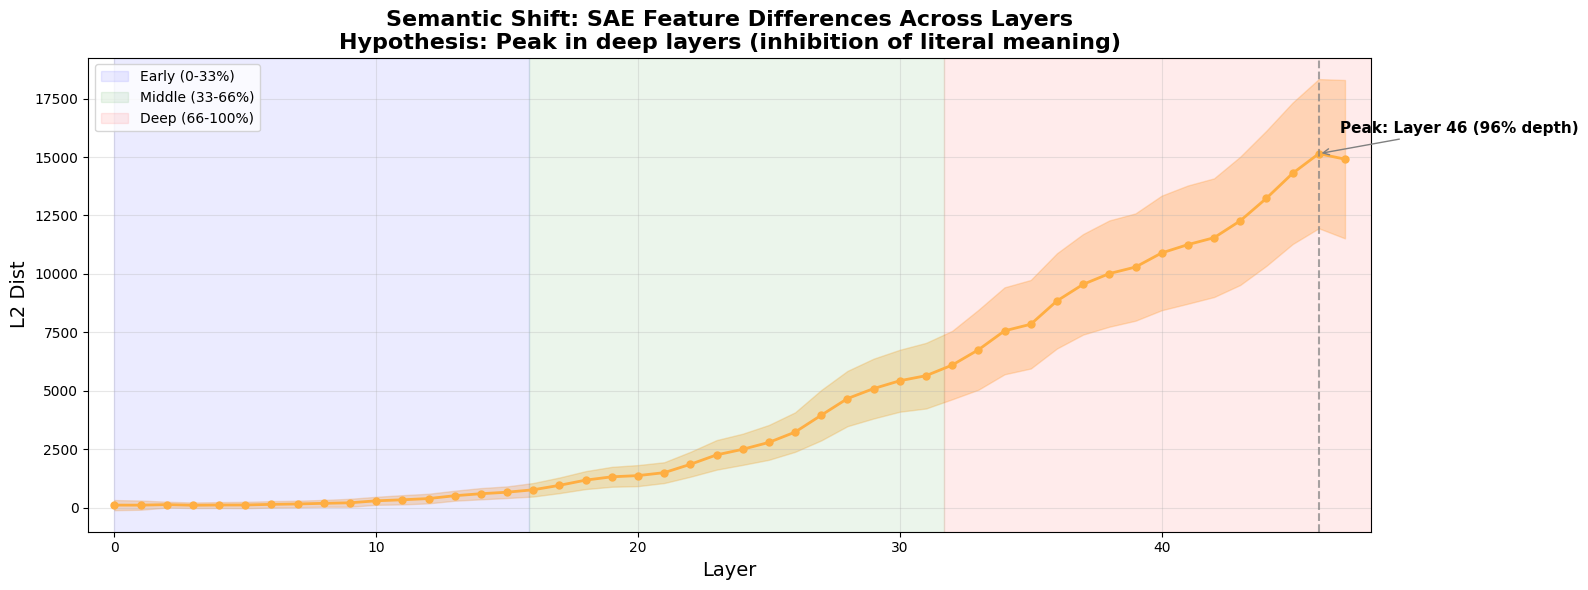

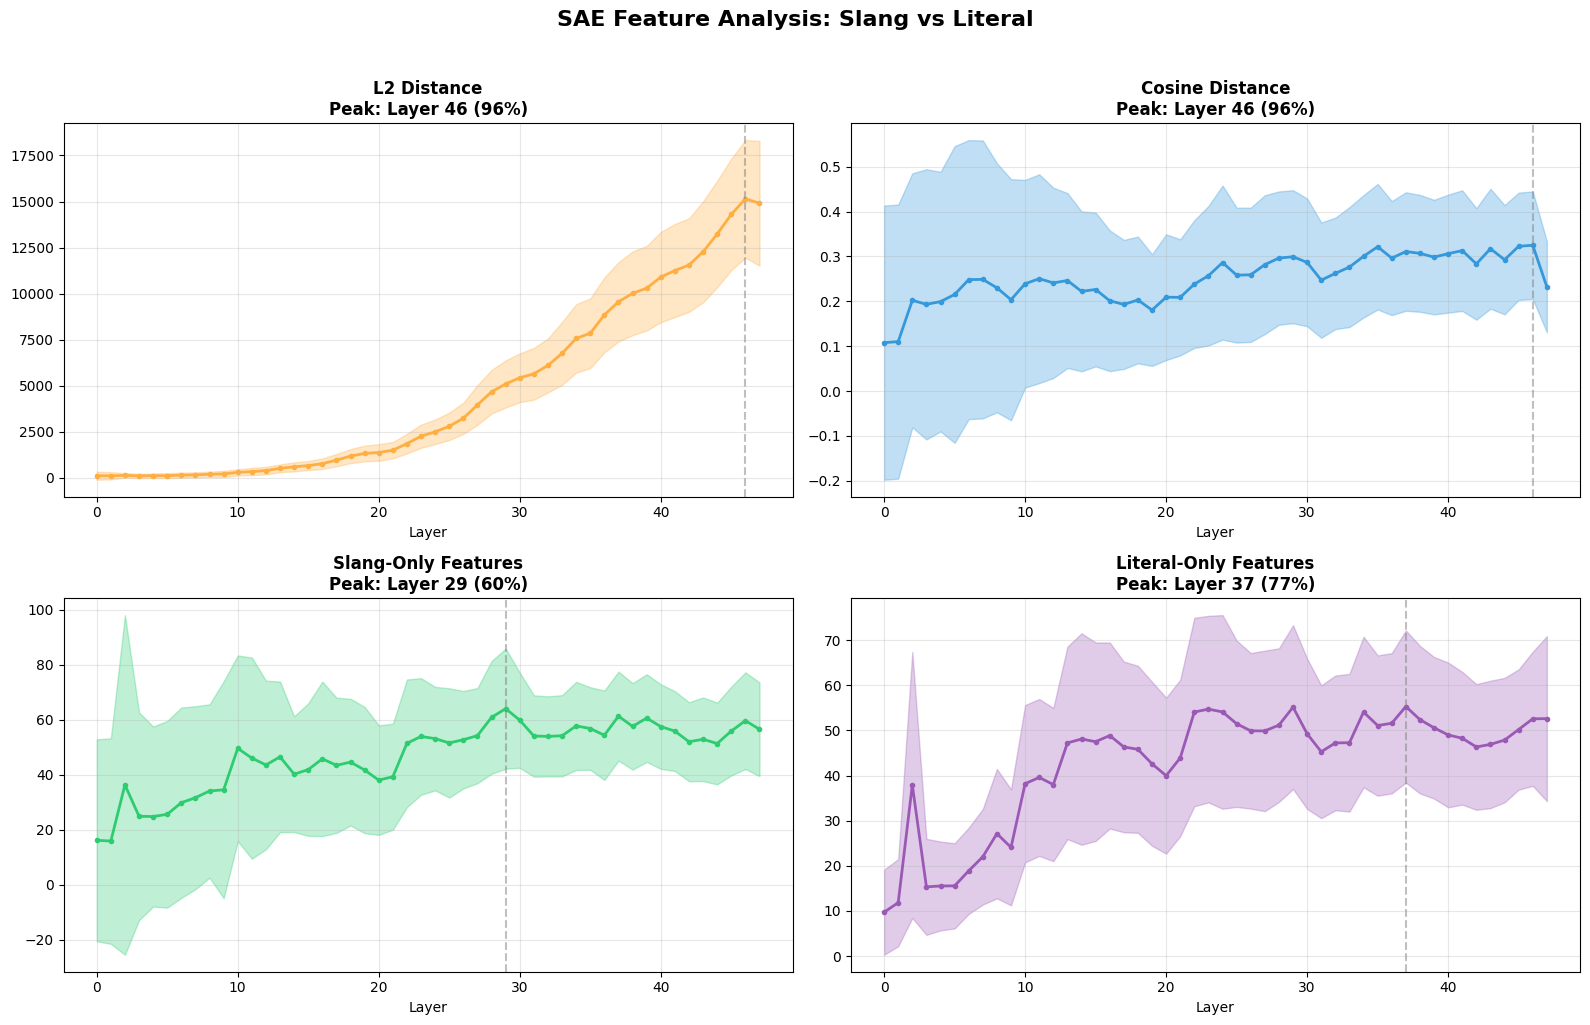

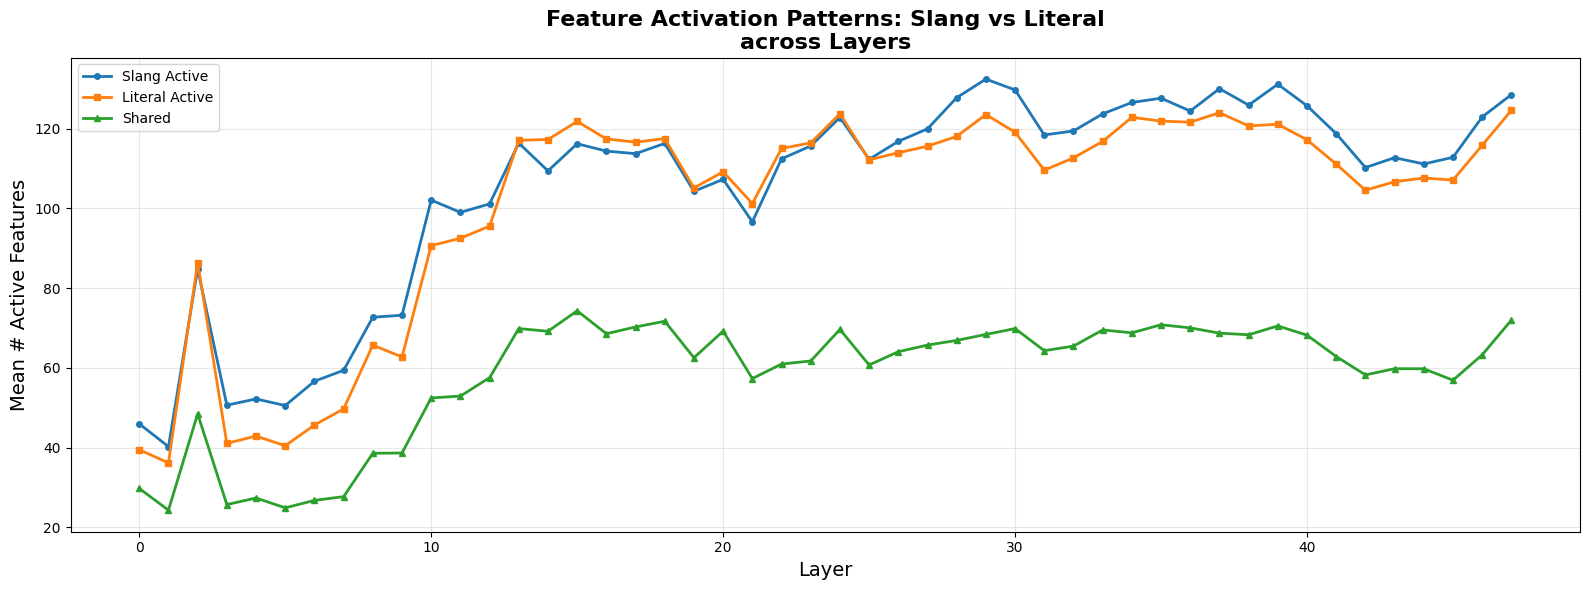

In [ ]:
## 8. Visualization

def plot_layer_differences(df: pd.DataFrame, metric: str = 'l2_dist'):
    """Plot SAE feature differences across all layers"""

    metric_df = df[df['metric'] == metric].sort_values('layer')

    if len(metric_df) == 0:
        print(f"No data for metric: {metric}")
        return None

    num_layers = int(metric_df['layer'].max()) + 1

    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot with error bands
    ax.fill_between(
        metric_df['layer'],
        metric_df['mean'] - metric_df['std'],
        metric_df['mean'] + metric_df['std'],
        alpha=0.3, color='#ffae42'
    )
    ax.plot(
        metric_df['layer'], metric_df['mean'],
        'o-', color='#ffae42', linewidth=2, markersize=5
    )

    # Mark peak
    peak_idx = metric_df['mean'].idxmax()
    peak = metric_df.loc[peak_idx]
    ax.axvline(x=peak['layer'], color='gray', linestyle='--', alpha=0.7)
    ax.annotate(
        f"Peak: Layer {int(peak['layer'])} ({100*peak['layer']/num_layers:.0f}% depth)",
        xy=(peak['layer'], peak['mean']),
        xytext=(15, 15), textcoords='offset points',
        fontsize=11, fontweight='bold',
        arrowprops=dict(arrowstyle='->', color='gray')
    )

    # Layer region shading
    ax.axvspan(0, num_layers*0.33, alpha=0.08, color='blue', label='Early (0-33%)')
    ax.axvspan(num_layers*0.33, num_layers*0.66, alpha=0.08, color='green', label='Middle (33-66%)')
    ax.axvspan(num_layers*0.66, num_layers, alpha=0.08, color='red', label='Deep (66-100%)')

    ax.set_xlabel('Layer', fontsize=14)
    ax.set_ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
    ax.set_title(
        f'Semantic Shift: SAE Feature Differences Across Layers\n'
        f'Hypothesis: Peak in deep layers (inhibition of literal meaning)',
        fontsize=16, fontweight='bold'
    )
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, num_layers)

    plt.tight_layout()
    plt.savefig('sae_layer_differences.png', dpi=150, bbox_inches='tight')
    plt.show()

    return peak

# Plot main result
peak = plot_layer_differences(results_df, 'l2_dist')


def plot_all_metrics(df: pd.DataFrame):
    """Plot multiple metrics side by side"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    metrics = ['l2_dist', 'cosine_dist', 'slang_only_features', 'literal_only_features']
    titles = ['L2 Distance', 'Cosine Distance', 'Slang-Only Features', 'Literal-Only Features']
    colors = ['#ffae42', '#3498db', '#2ecc71', '#9b59b6']

    for ax, metric, title, color in zip(axes.flat, metrics, titles, colors):
        metric_df = df[df['metric'] == metric].sort_values('layer')
        if len(metric_df) == 0:
            ax.set_title(f"{title}\nNo data", fontsize=12)
            continue

        num_layers = int(metric_df['layer'].max()) + 1

        ax.fill_between(
            metric_df['layer'],
            metric_df['mean'] - metric_df['std'],
            metric_df['mean'] + metric_df['std'],
            alpha=0.3, color=color
        )
        ax.plot(
            metric_df['layer'], metric_df['mean'],
            'o-', color=color, linewidth=2, markersize=3
        )

        # Peak
        peak_idx = metric_df['mean'].idxmax()
        peak = metric_df.loc[peak_idx]
        ax.axvline(x=peak['layer'], color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f"{title}\nPeak: Layer {int(peak['layer'])} ({100*peak['layer']/num_layers:.0f}%)",
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Layer')
        ax.grid(True, alpha=0.3)

    plt.suptitle('SAE Feature Analysis: Slang vs Literal', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('sae_all_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_all_metrics(results_df)


def plot_feature_activation_comparison(df: pd.DataFrame):
    """Compare feature activation patterns between slang and literal"""

    fig, ax = plt.subplots(figsize=(16, 6))

    slang_df = df[df['metric'] == 'slang_active'].sort_values('layer')
    literal_df = df[df['metric'] == 'literal_active'].sort_values('layer')
    shared_df = df[df['metric'] == 'shared_features'].sort_values('layer')

    if len(slang_df) == 0:
        print("No activation data available")
        return

    ax.plot(slang_df['layer'], slang_df['mean'], 'o-', label='Slang Active', linewidth=2, markersize=4)
    ax.plot(literal_df['layer'], literal_df['mean'], 's-', label='Literal Active', linewidth=2, markersize=4)
    ax.plot(shared_df['layer'], shared_df['mean'], '^-', label='Shared', linewidth=2, markersize=4)

    ax.set_xlabel('Layer', fontsize=14)
    ax.set_ylabel('Mean # Active Features', fontsize=14)
    ax.set_title('Feature Activation Patterns: Slang vs Literal\nacross Layers', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_activation_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_feature_activation_comparison(results_df)

In [ ]:
## 9. Statistical Analysis

def analyze_results(df: pd.DataFrame, metric: str = 'l2_dist'):
    """Statistical analysis of layer-wise differences"""

    metric_df = df[df['metric'] == metric].sort_values('layer')

    if len(metric_df) == 0:
        print(f"No data for metric: {metric}")
        return None

    num_layers = int(metric_df['layer'].max()) + 1

    # Define regions
    early_end = int(num_layers * 0.33)
    middle_end = int(num_layers * 0.66)

    early = list(range(0, early_end))
    middle = list(range(early_end, middle_end))
    deep = list(range(middle_end, num_layers))

    print("=" * 70)
    print("SEMANTIC SHIFT - SAE FEATURE ANALYSIS RESULTS")
    print("=" * 70)
    print(f"\nModel: Gemma-3-12B-IT")
    print(f"SAE: Gemma Scope 2 (262k width)")
    print(f"Dataset: {int(metric_df['n'].iloc[0])} pairs")
    print(f"Layers analyzed: {num_layers}")

    # Peak layer
    peak_idx = metric_df['mean'].idxmax()
    peak = metric_df.loc[peak_idx]
    peak_layer = int(peak['layer'])
    peak_pct = peak_layer / (num_layers - 1) * 100

    print(f"\n{'─' * 70}")
    print(f"PEAK ANALYSIS")
    print(f"{'─' * 70}")
    print(f"Peak Layer: {peak_layer} / {num_layers-1} ({peak_pct:.1f}% depth)")
    print(f"Peak Value: {peak['mean']:.4f} ± {peak['std']:.4f}")

    # Top 5 layers
    top5 = metric_df.nlargest(5, 'mean')
    print(f"\nTop 5 Layers: {top5['layer'].astype(int).tolist()}")

    # Region means
    early_df = metric_df[metric_df['layer'].isin(early)]
    middle_df = metric_df[metric_df['layer'].isin(middle)]
    deep_df = metric_df[metric_df['layer'].isin(deep)]

    early_mean = early_df['mean'].mean() if len(early_df) > 0 else np.nan
    middle_mean = middle_df['mean'].mean() if len(middle_df) > 0 else np.nan
    deep_mean = deep_df['mean'].mean() if len(deep_df) > 0 else np.nan

    print(f"\n{'─' * 70}")
    print(f"REGION ANALYSIS")
    print(f"{'─' * 70}")
    print(f"  Early  (layers 0-{early_end-1}):     {early_mean:.4f}")
    print(f"  Middle (layers {early_end}-{middle_end-1}):   {middle_mean:.4f}")
    print(f"  Deep   (layers {middle_end}-{num_layers-1}):   {deep_mean:.4f}")

    # Determine which region has highest mean
    region_means = {'Early': early_mean, 'Middle': middle_mean, 'Deep': deep_mean}
    max_region = max(region_means, key=region_means.get)
    print(f"\n  → Highest mean in: {max_region} layers")

    # Statistical tests
    early_vals = early_df['mean'].values
    middle_vals = middle_df['mean'].values
    deep_vals = deep_df['mean'].values

    results_dict = {
        'peak_layer': peak_layer,
        'peak_pct': peak_pct,
        'peak_value': peak['mean'],
        'early_mean': early_mean,
        'middle_mean': middle_mean,
        'deep_mean': deep_mean,
    }

    # Only do stats if we have enough data
    if len(early_vals) > 1 and len(middle_vals) > 1 and len(deep_vals) > 1:
        f_stat, p_val = stats.f_oneway(early_vals, middle_vals, deep_vals)
        print(f"\n{'─' * 70}")
        print(f"STATISTICAL TESTS")
        print(f"{'─' * 70}")
        print(f"ANOVA (3 regions): F={f_stat:.2f}, p={p_val:.6f}")
        if p_val < 0.05:
            print("  → Significant difference between regions!")

        results_dict['anova_f'] = f_stat
        results_dict['anova_p'] = p_val

        # Pairwise t-tests
        t_em, p_em = stats.ttest_ind(early_vals, middle_vals)
        t_md, p_md = stats.ttest_ind(middle_vals, deep_vals)
        t_ed, p_ed = stats.ttest_ind(early_vals, deep_vals)

        print(f"\nPairwise t-tests:")
        print(f"  Early vs Middle:  t={t_em:.2f}, p={p_em:.4f} {'*' if p_em < 0.05 else ''}")
        print(f"  Middle vs Deep:   t={t_md:.2f}, p={p_md:.4f} {'*' if p_md < 0.05 else ''}")
        print(f"  Early vs Deep:    t={t_ed:.2f}, p={p_ed:.4f} {'*' if p_ed < 0.05 else ''}")

    # Hypothesis validation
    print(f"\n{'=' * 70}")
    print("HYPOTHESIS VALIDATION")
    print("=" * 70)
    print(f"\nHypothesis: Semantic shift processed in DEEP layers (>66% depth)")
    print(f"Result: Peak at {peak_pct:.1f}% depth (Layer {peak_layer})")

    if peak_pct > 66:
        verdict = "✓ SUPPORTED"
        explanation = "Peak in deep layers as predicted!"
    elif peak_pct > 50:
        verdict = "◐ PARTIAL"
        explanation = "Peak in middle-to-deep region"
    elif peak_pct > 33:
        verdict = "◐ PARTIAL"
        explanation

# FIXED TOKEN_LEVEL CODE

In [ ]:
# Semantic Shift Slang Processing in LLMs
# TOKEN-LEVEL SAE Feature Analysis

# ## ACL 2025 Experiment - SAE Feature Analysis
#
# This notebook analyzes how **Semantic Shift slang** (e.g., "cook", "slay", "vibe")
# is processed across all 48 layers in Gemma-3-12B using **Gemma Scope 2 SAEs**.
#
# **KEY CHANGE:** This version extracts features at the **specific token position**
# where slang/literal words differ, NOT the last token of the entire sentence.
#
# **Hypothesis:** Semantic shift slang requires inhibiting the dominant literal meaning,
# so it should be processed primarily in **deep layers** (>66% depth).

# ## 1. Environment Setup

# !pip install -q transformers accelerate torch safetensors
# !pip install -q sae-lens
# !pip install datasets pandas numpy matplotlib seaborn scipy tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from tqdm.auto import tqdm
from difflib import SequenceMatcher
import json
import gc
import ast
import re
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer
from sae_lens import SAE

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# from huggingface_hub import login
# from google.colab import userdata
#
# try:
#     hf_token = userdata.get('HF_TOKEN')
#     login(token=hf_token)
#     print("Logged in via Colab secret")
# except:
#     print("Manual login:")
#     login()

# ## 2. Load Dataset with Tagged Positions

# from google.colab import files
# print("Upload the tagged CSV file:")
# uploaded = files.upload()

# For semantic shift dataset
# df = pd.read_csv('genz_dataset_tagged.csv')

# For neologism dataset
# df = pd.read_csv('neologism_tagged.csv')

# For constructions dataset
# df = pd.read_csv('constructions_tagged.csv')

@dataclass
class SlangPairWithPosition:
    """A slang sentence and its literal equivalent with token positions"""
    slang_text: str
    literal_text: str
    slang_positions: List[Tuple[int, int]]  # List of (start, end) word positions
    literal_positions: List[Tuple[int, int]]
    slang_segments: str  # The actual slang words/phrases
    literal_segments: str  # The literal equivalents


def load_semantic_shift_pairs(df: pd.DataFrame) -> List[SlangPairWithPosition]:
    """Load semantic shift dataset with position tags"""
    pairs = []
    for _, row in df.iterrows():
        try:
            slang_pos = ast.literal_eval(row['slang_positions'])
            literal_pos = ast.literal_eval(row['literal_positions'])

            pairs.append(SlangPairWithPosition(
                slang_text=str(row['gen_z']),
                literal_text=str(row['normal']),
                slang_positions=slang_pos,
                literal_positions=literal_pos,
                slang_segments=str(row.get('slang_segments', '')),
                literal_segments=str(row.get('literal_segments', ''))
            ))
        except Exception as e:
            continue
    return pairs


def load_neologism_pairs(df: pd.DataFrame) -> List[SlangPairWithPosition]:
    """Load neologism dataset with position tags"""
    pairs = []
    for _, row in df.iterrows():
        try:
            slang_pos = ast.literal_eval(row['slang_positions'])
            literal_pos = ast.literal_eval(row['literal_positions'])

            pairs.append(SlangPairWithPosition(
                slang_text=str(row['gen_z']),
                literal_text=str(row['normal']),
                slang_positions=slang_pos,
                literal_positions=literal_pos,
                slang_segments=str(row.get('slang_word', row.get('term', ''))),
                literal_segments=str(row.get('literal_replacement', ''))
            ))
        except Exception as e:
            continue
    return pairs


def load_construction_pairs(df: pd.DataFrame) -> List[SlangPairWithPosition]:
    """Load constructions dataset with position tags"""
    pairs = []
    for _, row in df.iterrows():
        try:
            slang_pos = ast.literal_eval(row['slang_positions'])
            literal_pos = ast.literal_eval(row['literal_positions'])

            pairs.append(SlangPairWithPosition(
                slang_text=str(row['gen_z']),
                literal_text=str(row['normal']),
                slang_positions=slang_pos,
                literal_positions=literal_pos,
                slang_segments=str(row.get('slang_in_sentence', row.get('construction', ''))),
                literal_segments=str(row.get('literal_replacement', ''))
            ))
        except Exception as e:
            continue
    return pairs


# === LOAD YOUR DATASET HERE ===
# Uncomment the appropriate loader:

# df = pd.read_csv('genz_dataset_tagged.csv')
# pairs = load_semantic_shift_pairs(df)

# df = pd.read_csv('neologism_tagged.csv')
# pairs = load_neologism_pairs(df)

# df = pd.read_csv('constructions_tagged.csv')
# pairs = load_construction_pairs(df)

# print(f"Created {len(pairs)} slang-literal pairs with position tags")
# print(f"\nExample:")
# print(f"  Literal: {pairs[0].literal_text}")
# print(f"  Slang:   {pairs[0].slang_text}")
# print(f"  Slang segments: {pairs[0].slang_segments}")
# print(f"  Literal segments: {pairs[0].literal_segments}")
# print(f"  Slang positions: {pairs[0].slang_positions}")
# print(f"  Literal positions: {pairs[0].literal_positions}")


# ## 3. Load Model

MODEL_ID = "google/gemma-3-12b-it"

print(f"Loading {MODEL_ID} in bfloat16...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16,  # Use bfloat16 for numerical stability
    attn_implementation="eager"
)
model.eval()

# Get model config - Gemma 3 uses nested config
if hasattr(model.config, 'text_config'):
    NUM_LAYERS = model.config.text_config.num_hidden_layers
    HIDDEN_SIZE = model.config.text_config.hidden_size
else:
    NUM_LAYERS = len(model.model.language_model.layers)
    HIDDEN_SIZE = model.model.language_model.layers[0].self_attn.q_proj.in_features

print(f"\nModel loaded!")
print(f"  Layers: {NUM_LAYERS}")
print(f"  Hidden size: {HIDDEN_SIZE}")
print(f"  GPU memory used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")


# ## 4. Activation Cache

class ActivationCache:
    """Captures layer activations via forward hooks"""

    def __init__(self, model):
        self.model = model
        self.activations: Dict[int, torch.Tensor] = {}
        self.hooks: List = []

    def _hook(self, layer_idx: int):
        def fn(module, input, output):
            if isinstance(output, tuple):
                self.activations[layer_idx] = output[0].detach()
            else:
                self.activations[layer_idx] = output.detach()
        return fn

    def _get_layers(self):
        """Get transformer layers - Gemma 3 specific path"""
        return self.model.model.language_model.layers

    def register(self, layers: Optional[List[int]] = None):
        self.clear()
        model_layers = self._get_layers()
        layers = layers or list(range(len(model_layers)))

        for idx in layers:
            hook = model_layers[idx].register_forward_hook(self._hook(idx))
            self.hooks.append(hook)
        return self

    def clear(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []
        self.activations = {}

    def get(self) -> Dict[int, torch.Tensor]:
        return self.activations


# ## 5. Token-Level Position Mapping

def word_to_token_position(text: str, word_positions: List[Tuple[int, int]], tokenizer) -> List[int]:
    """
    Robustly maps word positions (word indices) to token indices using character offsets.
    Handles punctuation and spacing correctly.
    """
    # 1. Analyze word boundaries to get character spans for each "word"
    # We use the same logic as the original dataset creation to match indices
    words = text.split()
    word_spans = []
    current_char = 0
    for word in words:
        # Find where this word actually starts in the text (skipping spaces)
        start = text.find(word, current_char)
        if start == -1: # Fallback if find fails (shouldn't happen if text matches)
             start = current_char
        end = start + len(word)
        word_spans.append((start, end))
        current_char = end

    # 2. Get Token Offsets
    encoding = tokenizer(text, return_offsets_mapping=True, add_special_tokens=True)
    offsets = encoding['offset_mapping']

    target_token_indices = set()

    for start_word_idx, end_word_idx in word_positions:
        # Safely get character range for the target phrase
        if start_word_idx >= len(word_spans): continue

        # Determine valid range
        valid_end_idx = min(end_word_idx, len(word_spans))
        if start_word_idx >= valid_end_idx: continue

        char_start = word_spans[start_word_idx][0]
        char_end = word_spans[valid_end_idx - 1][1] # End of the last word

        # 3. Find tokens that fall within this character range
        for i, (tok_start, tok_end) in enumerate(offsets):
            if tok_start == 0 and tok_end == 0: continue # Skip special tokens

            # Intersection check: Token must overlap significantly with the word range
            # We use a loose overlap: if the token is mostly inside the word boundaries
            if (tok_start >= char_start and tok_start < char_end) or \
               (tok_end > char_start and tok_end <= char_end):
                target_token_indices.add(i)

    return sorted(list(target_token_indices))


def get_first_diff_token_position(text: str, word_positions: List[Tuple[int, int]], tokenizer) -> int:
    """
    Get the token position of the FIRST differing word.
    Falls back to middle of sentence if positions are invalid.
    """
    if not word_positions:
        # Fallback: use middle token
        tokens = tokenizer(text, return_tensors="pt")['input_ids']
        return tokens.shape[1] // 2

    token_indices = word_to_token_position(text, word_positions[:1], tokenizer)  # Just first diff

    if token_indices:
        return min(token_indices)  # Return first token of first diff
    else:
        # Fallback
        tokens = tokenizer(text, return_tensors="pt")['input_ids']
        return tokens.shape[1] // 2


# ## 6. Token-Level SAE Feature Extraction

def analyze_pairs_single_layer_token_level(
    pairs: List[SlangPairWithPosition],
    layer: int,
    width: str = "262k",
    l0: str = "big",
    max_pairs: Optional[int] = None,
    pooling: str = "first_diff"  # "first_diff", "all_diff", or "last"
) -> pd.DataFrame:
    """
    Analyze all pairs for a single layer using TOKEN-LEVEL positions.

    Args:
        pairs: List of SlangPairWithPosition
        layer: Layer to analyze
        width: SAE width ("16k" or "262k")
        l0: SAE sparsity ("small" or "big")
        max_pairs: Maximum pairs to process
        pooling: How to pool activations:
            - "first_diff": Use first differing token position
            - "all_diff": Average over all differing token positions
            - "last": Use last token (original behavior)
    """
    if max_pairs:
        pairs = pairs[:max_pairs]

    # Load SAE for this layer only
    print(f"\nLoading SAE for layer {layer}...")
    sae, _, _ = SAE.from_pretrained(
        release="gemma-scope-2-12b-it-res-all",
        sae_id=f"layer_{layer}_width_{width}_l0_{l0}",
    )
    sae = sae.to(device)
    print(f"  ✓ Loaded (d_sae={sae.cfg.d_sae})")

    # Metrics storage
    metrics = {
        'l1_dist': [],
        'l2_dist': [],
        'cosine_dist': [],
        'slang_only_features': [],
        'literal_only_features': [],
        'shared_features': [],
        'slang_active': [],
        'literal_active': []
    }

    skipped = 0
    for pair in tqdm(pairs, desc=f"Layer {layer}"):
        try:
            # === SLANG SENTENCE ===
            slang_inputs = tokenizer(pair.slang_text, return_tensors="pt", truncation=True, max_length=512)
            slang_inputs = {k: v.to(device) for k, v in slang_inputs.items()}
            seq_len_slang = slang_inputs['input_ids'].shape[1]

            cache = ActivationCache(model)
            cache.register([layer])
            with torch.no_grad():
                model(**slang_inputs)
            slang_acts_full = cache.get()[layer].squeeze(0)  # (seq_len, hidden_dim)
            cache.clear()

            # Get token position for slang
            if pooling == "first_diff":
                slang_pos = get_first_diff_token_position(pair.slang_text, pair.slang_positions, tokenizer)
                slang_pos = min(slang_pos, seq_len_slang - 1)  # Clamp to valid range
                slang_acts = slang_acts_full[slang_pos]
            elif pooling == "all_diff":
                token_indices = word_to_token_position(pair.slang_text, pair.slang_positions, tokenizer)

                if len(pairs) < 5: # 只在前幾個 pair 印出 debug 資訊，避免刷屏
                    print(f"\n[DEBUG] Pair: {pair.slang_segments}")
                    tokens = tokenizer.convert_ids_to_tokens(slang_inputs['input_ids'][0][token_indices])
                    print(f"        Caught Tokens: {tokens} (Indices: {token_indices})")
                # ---------------------

                if token_indices:
                    token_indices = [min(t, seq_len_slang - 1) for t in token_indices]
                    slang_acts = slang_acts_full[token_indices].mean(dim=0)
                else:
                    slang_acts = slang_acts_full[-1]

                if token_indices:
                    token_indices = [min(t, seq_len_slang - 1) for t in token_indices]
                    slang_acts = slang_acts_full[token_indices].mean(dim=0)
                else:
                    slang_acts = slang_acts_full[-1]
            else:  # "last"
                slang_acts = slang_acts_full[-1]

            sf = sae.encode(slang_acts.unsqueeze(0).to(sae.W_enc.dtype)).squeeze(0).cpu()

            # === LITERAL SENTENCE ===
            literal_inputs = tokenizer(pair.literal_text, return_tensors="pt", truncation=True, max_length=512)
            literal_inputs = {k: v.to(device) for k, v in literal_inputs.items()}
            seq_len_literal = literal_inputs['input_ids'].shape[1]

            cache = ActivationCache(model)
            cache.register([layer])
            with torch.no_grad():
                model(**literal_inputs)
            literal_acts_full = cache.get()[layer].squeeze(0)
            cache.clear()

            # Get token position for literal
            if pooling == "first_diff":
                literal_pos = get_first_diff_token_position(pair.literal_text, pair.literal_positions, tokenizer)
                literal_pos = min(literal_pos, seq_len_literal - 1)
                literal_acts = literal_acts_full[literal_pos]
            elif pooling == "all_diff":
                token_indices = word_to_token_position(pair.literal_text, pair.literal_positions, tokenizer)

                if len(pairs) < 5: # 只在前幾個 pair 印出 debug 資訊，避免刷屏
                    print(f"\n[DEBUG] Pair: {pair.slang_segments}")
                    tokens = tokenizer.convert_ids_to_tokens(slang_inputs['input_ids'][0][token_indices])
                    print(f"        Caught Tokens: {tokens} (Indices: {token_indices})")
                # ---------------------

                if token_indices:
                    token_indices = [min(t, seq_len_slang - 1) for t in token_indices]
                    slang_acts = slang_acts_full[token_indices].mean(dim=0)
                else:
                    slang_acts = slang_acts_full[-1]

                if token_indices:
                    token_indices = [min(t, seq_len_literal - 1) for t in token_indices]
                    literal_acts = literal_acts_full[token_indices].mean(dim=0)
                else:
                    literal_acts = literal_acts_full[-1]
            else:
                literal_acts = literal_acts_full[-1]

            lf = sae.encode(literal_acts.unsqueeze(0).to(sae.W_enc.dtype)).squeeze(0).cpu()

            # === COMPUTE METRICS ===
            metrics['l1_dist'].append(torch.norm(sf - lf, p=1).item())
            metrics['l2_dist'].append(torch.norm(sf - lf, p=2).item())

            if sf.norm() > 0 and lf.norm() > 0:
                cos = 1 - F.cosine_similarity(sf.unsqueeze(0), lf.unsqueeze(0)).item()
            else:
                cos = 1.0
            metrics['cosine_dist'].append(cos)

            slang_active = sf > 0
            literal_active = lf > 0
            metrics['slang_only_features'].append((slang_active & ~literal_active).sum().item())
            metrics['literal_only_features'].append((~slang_active & literal_active).sum().item())
            metrics['shared_features'].append((slang_active & literal_active).sum().item())
            metrics['slang_active'].append(slang_active.sum().item())
            metrics['literal_active'].append(literal_active.sum().item())

        except Exception as e:
            skipped += 1
            if skipped <= 3:
                print(f"Error: {e}")
            continue

    # Free SAE memory
    del sae
    torch.cuda.empty_cache()
    gc.collect()
    print(f"  ✓ Layer {layer} complete, SAE freed (skipped {skipped} pairs)")

    # Build DataFrame for this layer
    rows = []
    for metric_name, values in metrics.items():
        if len(values) > 0:
            rows.append({
                'layer': layer,
                'metric': metric_name,
                'mean': np.mean(values),
                'std': np.std(values),
                'n': len(values)
            })

    return pd.DataFrame(rows)


def analyze_all_layers_sequential_token_level(
    pairs: List[SlangPairWithPosition],
    num_layers: int = 48,
    start_layer: int = 0,
    width: str = "16k",
    l0: str = "big",
    max_pairs: Optional[int] = None,
    pooling: str = "first_diff"
) -> pd.DataFrame:
    """Process all layers one at a time using token-level positions."""

    all_results = []

    for layer in range(start_layer, num_layers):
        layer_df = analyze_pairs_single_layer_token_level(
            pairs, layer, width=width, l0=l0, max_pairs=max_pairs, pooling=pooling
        )
        all_results.append(layer_df)

        # Save checkpoint every 10 layers
        if (layer + 1) % 10 == 0:
            checkpoint_df = pd.concat(all_results, ignore_index=True)
            checkpoint_df.to_csv(f'checkpoint_token_level_layer_{layer+1}.csv', index=False)
            print(f"  💾 Checkpoint saved: checkpoint_token_level_layer_{layer+1}.csv")

    return pd.concat(all_results, ignore_index=True)


# ## 7. RUN THE ANALYSIS

# === EXAMPLE USAGE ===
#
# # Load your tagged dataset
# df = pd.read_csv('genz_dataset_tagged.csv')
# pairs = load_semantic_shift_pairs(df)
#
# print(f"Loaded {len(pairs)} pairs")
#
# # Run token-level analysis
# results_df = analyze_all_layers_sequential_token_level(
#     pairs,
#     num_layers=NUM_LAYERS,
#     start_layer=0,
#     width="262k",
#     l0="big",
#     max_pairs=None,  # Set to 100 for quick test
#     pooling="first_diff"  # Use first differing token position
# )
#
# print(f"\n✓ All layers complete!")
# print(f"Results shape: {results_df.shape}")
# results_df.to_csv('sae_token_level_results.csv', index=False)


# ## 8. Visualization (same as before)

def plot_layer_differences(df: pd.DataFrame, metric: str = 'l2_dist', title_prefix: str = ""):
    """Plot SAE feature differences across all layers"""

    metric_df = df[df['metric'] == metric].sort_values('layer')

    if len(metric_df) == 0:
        print(f"No data for metric: {metric}")
        return None

    num_layers = int(metric_df['layer'].max()) + 1

    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot with error bands
    ax.fill_between(
        metric_df['layer'],
        metric_df['mean'] - metric_df['std'],
        metric_df['mean'] + metric_df['std'],
        alpha=0.3, color='#e74c3c'
    )
    ax.plot(
        metric_df['layer'], metric_df['mean'],
        'o-', color='#e74c3c', linewidth=2, markersize=5
    )

    # Mark peak
    peak_idx = metric_df['mean'].idxmax()
    peak = metric_df.loc[peak_idx]
    ax.axvline(x=peak['layer'], color='gray', linestyle='--', alpha=0.7)
    ax.annotate(
        f"Peak: Layer {int(peak['layer'])} ({100*peak['layer']/(num_layers-1):.0f}% depth)",
        xy=(peak['layer'], peak['mean']),
        xytext=(15, 15), textcoords='offset points',
        fontsize=11, fontweight='bold',
        arrowprops=dict(arrowstyle='->', color='gray')
    )

    # Layer region shading
    ax.axvspan(0, num_layers*0.33, alpha=0.08, color='blue', label='Early (0-33%)')
    ax.axvspan(num_layers*0.33, num_layers*0.66, alpha=0.08, color='green', label='Middle (33-66%)')
    ax.axvspan(num_layers*0.66, num_layers, alpha=0.08, color='red', label='Deep (66-100%)')

    ax.set_xlabel('Layer', fontsize=14)
    ax.set_ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
    ax.set_title(
        f'{title_prefix}TOKEN-LEVEL SAE Feature Differences\n'
        f'Comparing activations at SPECIFIC differing token positions',
        fontsize=16, fontweight='bold'
    )
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, num_layers)

    plt.tight_layout()
    plt.savefig('sae_token_level_differences.png', dpi=150, bbox_inches='tight')
    plt.show()

    return peak


def plot_all_metrics(df: pd.DataFrame):
    """Plot multiple metrics side by side"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    metrics = ['l2_dist', 'cosine_dist', 'slang_only_features', 'literal_only_features']
    titles = ['L2 Distance', 'Cosine Distance', 'Slang-Only Features', 'Literal-Only Features']
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

    for ax, metric, title, color in zip(axes.flat, metrics, titles, colors):
        metric_df = df[df['metric'] == metric].sort_values('layer')
        if len(metric_df) == 0:
            ax.set_title(f"{title}\nNo data", fontsize=12)
            continue

        num_layers = int(metric_df['layer'].max()) + 1

        ax.fill_between(
            metric_df['layer'],
            metric_df['mean'] - metric_df['std'],
            metric_df['mean'] + metric_df['std'],
            alpha=0.3, color=color
        )
        ax.plot(
            metric_df['layer'], metric_df['mean'],
            'o-', color=color, linewidth=2, markersize=3
        )

        # Peak
        peak_idx = metric_df['mean'].idxmax()
        peak = metric_df.loc[peak_idx]
        ax.axvline(x=peak['layer'], color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f"{title}\nPeak: Layer {int(peak['layer'])} ({100*peak['layer']/(num_layers-1):.0f}%)",
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Layer')
        ax.grid(True, alpha=0.3)

    plt.suptitle('TOKEN-LEVEL SAE Feature Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('sae_token_level_all_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()


# ## 9. Statistical Analysis

def analyze_results(df: pd.DataFrame, metric: str = 'l2_dist'):
    """Statistical analysis of layer-wise differences"""

    metric_df = df[df['metric'] == metric].sort_values('layer')

    if len(metric_df) == 0:
        print(f"No data for metric: {metric}")
        return None

    num_layers = int(metric_df['layer'].max()) + 1

    # Define regions
    early_end = int(num_layers * 0.33)
    middle_end = int(num_layers * 0.66)

    early = list(range(0, early_end))
    middle = list(range(early_end, middle_end))
    deep = list(range(middle_end, num_layers))

    print("=" * 70)
    print("TOKEN-LEVEL SAE FEATURE ANALYSIS RESULTS")
    print("=" * 70)
    print(f"\nModel: Gemma-3-12B-IT")
    print(f"SAE: Gemma Scope 2 (262k width)")
    print(f"Dataset: {int(metric_df['n'].iloc[0])} pairs")
    print(f"Layers analyzed: {num_layers}")
    print(f"\n*** Using TOKEN-LEVEL positions (not sentence-level) ***")

    # Peak layer
    peak_idx = metric_df['mean'].idxmax()
    peak = metric_df.loc[peak_idx]
    peak_layer = int(peak['layer'])
    peak_pct = peak_layer / (num_layers - 1) * 100

    print(f"\n{'─' * 70}")
    print(f"PEAK ANALYSIS")
    print(f"{'─' * 70}")
    print(f"Peak Layer: {peak_layer} / {num_layers-1} ({peak_pct:.1f}% depth)")
    print(f"Peak Value: {peak['mean']:.4f} ± {peak['std']:.4f}")

    # Top 5 layers
    top5 = metric_df.nlargest(5, 'mean')
    print(f"\nTop 5 Layers: {top5['layer'].astype(int).tolist()}")

    # Region means
    early_df = metric_df[metric_df['layer'].isin(early)]
    middle_df = metric_df[metric_df['layer'].isin(middle)]
    deep_df = metric_df[metric_df['layer'].isin(deep)]

    early_mean = early_df['mean'].mean() if len(early_df) > 0 else np.nan
    middle_mean = middle_df['mean'].mean() if len(middle_df) > 0 else np.nan
    deep_mean = deep_df['mean'].mean() if len(deep_df) > 0 else np.nan

    print(f"\n{'─' * 70}")
    print(f"REGION ANALYSIS")
    print(f"{'─' * 70}")
    print(f"  Early  (layers 0-{early_end-1}):     {early_mean:.4f}")
    print(f"  Middle (layers {early_end}-{middle_end-1}):   {middle_mean:.4f}")
    print(f"  Deep   (layers {middle_end}-{num_layers-1}):   {deep_mean:.4f}")

    # Determine which region has highest mean
    region_means = {'Early': early_mean, 'Middle': middle_mean, 'Deep': deep_mean}
    max_region = max(region_means, key=region_means.get)
    print(f"\n  → Highest mean in: {max_region} layers")

    # Statistical tests
    early_vals = early_df['mean'].values
    middle_vals = middle_df['mean'].values
    deep_vals = deep_df['mean'].values

    results_dict = {
        'peak_layer': peak_layer,
        'peak_pct': peak_pct,
        'peak_value': peak['mean'],
        'early_mean': early_mean,
        'middle_mean': middle_mean,
        'deep_mean': deep_mean,
    }

    # Only do stats if we have enough data
    if len(early_vals) > 1 and len(middle_vals) > 1 and len(deep_vals) > 1:
        f_stat, p_val = stats.f_oneway(early_vals, middle_vals, deep_vals)
        print(f"\n{'─' * 70}")
        print(f"STATISTICAL TESTS")
        print(f"{'─' * 70}")
        print(f"ANOVA (3 regions): F={f_stat:.2f}, p={p_val:.6f}")
        if p_val < 0.05:
            print("  → Significant difference between regions!")

        results_dict['anova_f'] = f_stat
        results_dict['anova_p'] = p_val

        # Pairwise t-tests
        t_em, p_em = stats.ttest_ind(early_vals, middle_vals)
        t_md, p_md = stats.ttest_ind(middle_vals, deep_vals)
        t_ed, p_ed = stats.ttest_ind(early_vals, deep_vals)

        print(f"\nPairwise t-tests:")
        print(f"  Early vs Middle:  t={t_em:.2f}, p={p_em:.4f} {'*' if p_em < 0.05 else ''}")
        print(f"  Middle vs Deep:   t={t_md:.2f}, p={p_md:.4f} {'*' if p_md < 0.05 else ''}")
        print(f"  Early vs Deep:    t={t_ed:.2f}, p={p_ed:.4f} {'*' if p_ed < 0.05 else ''}")

    # Hypothesis validation
    print(f"\n{'=' * 70}")
    print("HYPOTHESIS VALIDATION")
    print("=" * 70)
    print(f"\nHypothesis: Semantic shift processed in DEEP layers (>66% depth)")
    print(f"Result: Peak at {peak_pct:.1f}% depth (Layer {peak_layer})")

    if peak_pct > 66:
        verdict = "✓ SUPPORTED"
        explanation = "Peak in deep layers as predicted!"
    elif peak_pct > 50:
        verdict = "◐ PARTIAL"
        explanation = "Peak in middle-to-deep region"
    elif peak_pct > 33:
        verdict = "◐ PARTIAL"
        explanation = "Peak in middle layers"
    else:
        verdict = "✗ NOT SUPPORTED"
        explanation = "Peak in early layers"

    print(f"\n{verdict}: {explanation}")
    results_dict['verdict'] = verdict

    return results_dict


# ## 10. Quick Test Function

def quick_test_token_positions(pairs: List[SlangPairWithPosition], n: int = 5):
    """
    Test that token positions are being extracted correctly.
    Updated to show ALL tokens corresponding to the segments.
    """
    print("=" * 70)
    print("TOKEN POSITION VERIFICATION (MULTI-TOKEN CHECK)")
    print("=" * 70)

    for i, pair in enumerate(pairs[:n]):
        print(f"\n--- Example {i+1} ---")
        print(f"Slang: {pair.slang_text}")
        print(f"Literal: {pair.literal_text}")

        # -------------------------------------------------------
        # 1. 檢查 Slang (改用 word_to_token_position)
        # -------------------------------------------------------
        print(f"Slang segments: {pair.slang_segments}")

        # 取得所有 tokens 的位置
        slang_indices = word_to_token_position(pair.slang_text, pair.slang_positions, tokenizer)

        # 轉回文字顯示
        s_ids = tokenizer(pair.slang_text, return_tensors="pt")['input_ids'][0]
        # 過濾掉超出的索引 (防呆)
        valid_s_indices = [idx for idx in slang_indices if idx < len(s_ids)]
        slang_tokens = tokenizer.convert_ids_to_tokens(s_ids[valid_s_indices])

        print(f"Slang tokens:   {slang_tokens}")
        print(f"   (Indices: {slang_indices})")

        # -------------------------------------------------------
        # 2. 檢查 Literal
        # -------------------------------------------------------
        print(f"Literal segments: {pair.literal_segments}")

        literal_indices = word_to_token_position(pair.literal_text, pair.literal_positions, tokenizer)

        l_ids = tokenizer(pair.literal_text, return_tensors="pt")['input_ids'][0]
        valid_l_indices = [idx for idx in literal_indices if idx < len(l_ids)]
        literal_tokens = tokenizer.convert_ids_to_tokens(l_ids[valid_l_indices])

        print(f"Literal tokens: {literal_tokens}")
        print(f"   (Indices: {literal_indices})")


Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.17 GB
Loading google/gemma-3-12b-it in bfloat16...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/916 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/109k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/4.60G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]


Model loaded!
  Layers: 48
  Hidden size: 3840
  GPU memory used: 24.38 GB


In [ ]:
print("="*80)
print("   FULL TOKEN SEGMENT VERIFICATION (SLANG & LITERAL)")
print("="*80)

for i in range(5):  # 檢查前 5 個例子
    pair = pairs[i]

    print(f"\n--- Example {i+1} ---")

    # ==========================
    # 1. Check Slang
    # ==========================
    print(f"🔹 [Slang] Segment: '{pair.slang_segments}'")
    slang_indices = word_to_token_position(pair.slang_text, pair.slang_positions, tokenizer)

    # Decode Slang Tokens
    s_inputs = tokenizer(pair.slang_text, return_tensors="pt")
    s_ids = s_inputs['input_ids'][0]
    s_valid_indices = [idx for idx in slang_indices if idx < len(s_ids)]
    s_tokens = tokenizer.convert_ids_to_tokens(s_ids[s_valid_indices])

    print(f"    Tokens:  {s_tokens}")
    print(f"    Indices: {slang_indices}")

    # ==========================
    # 2. Check Literal
    # ==========================
    print(f"🔸 [Literal] Segment: '{pair.literal_segments}'")
    literal_indices = word_to_token_position(pair.literal_text, pair.literal_positions, tokenizer)

    # Decode Literal Tokens
    l_inputs = tokenizer(pair.literal_text, return_tensors="pt")
    l_ids = l_inputs['input_ids'][0]
    l_valid_indices = [idx for idx in literal_indices if idx < len(l_ids)]
    l_tokens = tokenizer.convert_ids_to_tokens(l_ids[l_valid_indices])

    print(f"    Tokens:  {l_tokens}")
    print(f"    Indices: {literal_indices}")

    # Check Validity
    if len(literal_indices) > 1:
        print("    ✅ Literal pooling active (multiple tokens)")
    else:
        print("    ⚠️ Literal: Single token (Check if word is short, e.g., 'I')")

print("\n" + "="*80)

   FULL TOKEN SEGMENT VERIFICATION (SLANG & LITERAL)


NameError: name 'pairs' is not defined

TOKEN POSITION VERIFICATION (MULTI-TOKEN CHECK)

--- Example 1 ---
Slang: I caught myself typing qwertyuiopasdfghjklzxcvbnm during the boring lecture.
Literal: I caught myself mindlessly typing across the keyboard during the boring lecture.
Slang segments: qwertyuiopasdfghjklzxcvbnm
Slang tokens:   ['▁qw', 'erty', 'ui', 'op', 'as', 'df', 'gh', 'j', 'kl', 'z', 'xc', 'v', 'bn', 'm']
   (Indices: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
Literal segments: mindlessly | across the keyboard
Literal tokens: ['▁mind', 'lessly', '▁across', '▁the', '▁keyboard']
   (Indices: [4, 5, 7, 8, 9])

--- Example 2 ---
Slang: "I identify as heteroflexible," she explained.
Literal: "I identify as mostly straight but open to exceptions," she explained.
Slang segments: heteroflexible
Slang tokens:   ['▁heter', 'of', 'lex', 'ible', ',"']
   (Indices: [5, 6, 7, 8, 9])
Literal segments: mostly straight but open to exceptions,"
Literal tokens: ['▁mostly', '▁straight', '▁but', '▁open', '▁to', '▁excepti

config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_0_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 0:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 0 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 1...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_1_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 1:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 1 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 2...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_2_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 2:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 2 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 3...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_3_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 3:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 3 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 4...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_4_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 4:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 4 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 5...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_5_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 5:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 5 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 6...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_6_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 6:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 6 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 7...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_7_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 7:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 7 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 8...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_8_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 8:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 8 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 9...


config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

resid_post_all/layer_9_width_16k_l0_big/(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 9:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 9 complete, SAE freed (skipped 0 pairs)
  💾 Checkpoint saved: checkpoint_token_level_layer_10.csv

Loading SAE for layer 10...


config.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

resid_post_all/layer_10_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 10:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 10 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 11...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_11_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 11:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 11 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 12...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_12_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 12:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 12 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 13...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_13_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 13:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 13 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 14...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_14_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 14:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 14 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 15...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_15_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 15:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 15 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 16...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_16_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 16:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 16 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 17...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_17_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 17:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 17 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 18...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_18_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 18:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 18 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 19...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_19_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 19:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 19 complete, SAE freed (skipped 0 pairs)
  💾 Checkpoint saved: checkpoint_token_level_layer_20.csv

Loading SAE for layer 20...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_20_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 20:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 20 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 21...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_21_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 21:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 21 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 22...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_22_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 22:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 22 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 23...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_23_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 23:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 23 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 24...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_24_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 24:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 24 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 25...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_25_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 25:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 25 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 26...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_26_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 26:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 26 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 27...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_27_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 27:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 27 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 28...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_28_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 28:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 28 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 29...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_29_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 29:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 29 complete, SAE freed (skipped 0 pairs)
  💾 Checkpoint saved: checkpoint_token_level_layer_30.csv

Loading SAE for layer 30...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_30_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 30:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 30 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 31...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_31_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 31:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 31 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 32...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_32_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 32:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 32 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 33...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_33_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 33:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 33 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 34...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_34_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 34:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 34 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 35...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_35_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 35:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 35 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 36...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_36_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 36:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 36 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 37...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_37_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 37:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 37 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 38...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_38_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 38:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 38 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 39...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_39_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 39:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 39 complete, SAE freed (skipped 0 pairs)
  💾 Checkpoint saved: checkpoint_token_level_layer_40.csv

Loading SAE for layer 40...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_40_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 40:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 40 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 41...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_41_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 41:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 41 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 42...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_42_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 42:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 42 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 43...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_43_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 43:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 43 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 44...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_44_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 44:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 44 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 45...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_45_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 45:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 45 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 46...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_46_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 46:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 46 complete, SAE freed (skipped 0 pairs)

Loading SAE for layer 47...


config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

resid_post_all/layer_47_width_16k_l0_big(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

  ✓ Loaded (d_sae=16384)


Layer 47:   0%|          | 0/1000 [00:00<?, ?it/s]

  ✓ Layer 47 complete, SAE freed (skipped 0 pairs)


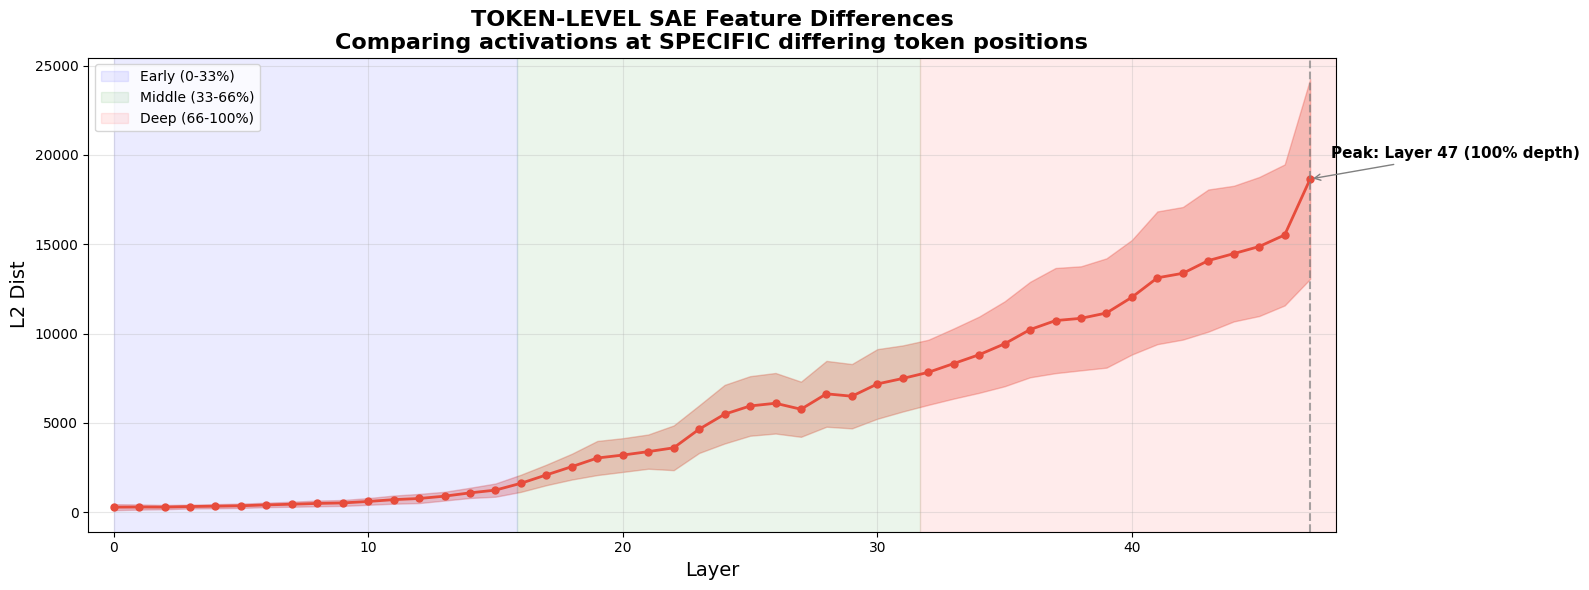

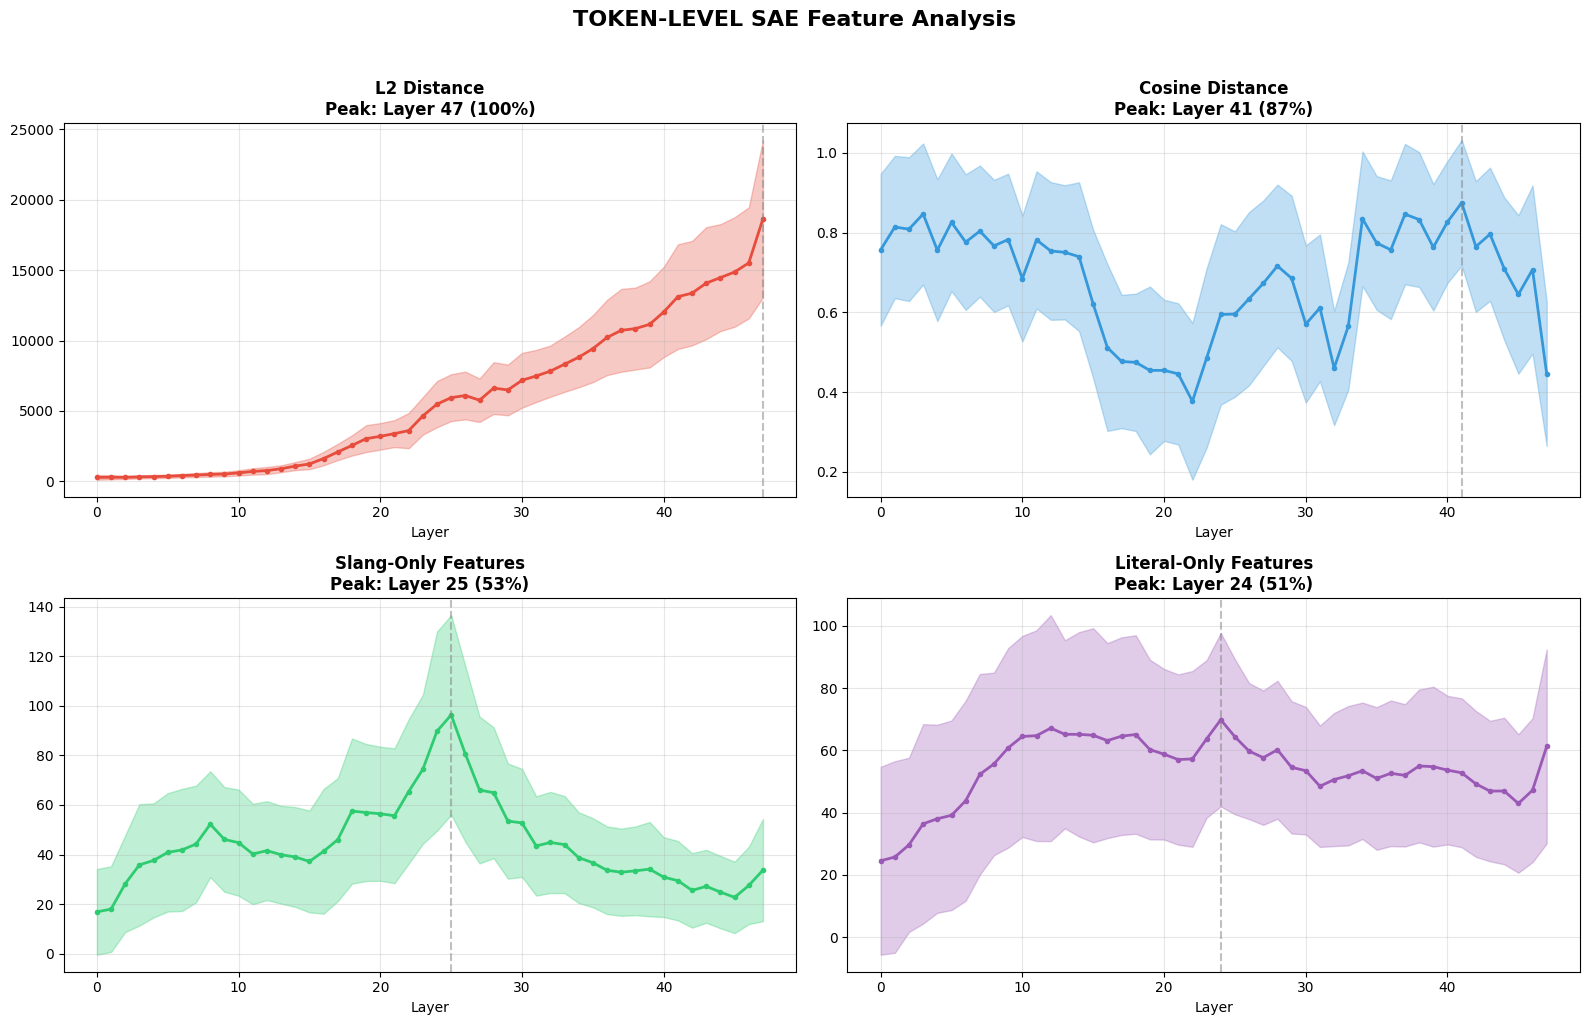

TOKEN-LEVEL SAE FEATURE ANALYSIS RESULTS

Model: Gemma-3-12B-IT
SAE: Gemma Scope 2 (262k width)
Dataset: 1000 pairs
Layers analyzed: 48

*** Using TOKEN-LEVEL positions (not sentence-level) ***

──────────────────────────────────────────────────────────────────────
PEAK ANALYSIS
──────────────────────────────────────────────────────────────────────
Peak Layer: 47 / 47 (100.0% depth)
Peak Value: 18649.2252 ± 5593.8387

Top 5 Layers: [47, 46, 45, 44, 43]

──────────────────────────────────────────────────────────────────────
REGION ANALYSIS
──────────────────────────────────────────────────────────────────────
  Early  (layers 0-14):     516.3837
  Middle (layers 15-30):   4307.4961
  Deep   (layers 31-47):   11819.4411

  → Highest mean in: Deep layers

──────────────────────────────────────────────────────────────────────
STATISTICAL TESTS
──────────────────────────────────────────────────────────────────────
ANOVA (3 regions): F=114.43, p=0.000000
  → Significant difference between re

In [ ]:
df = pd.read_csv('neologism_tagged.csv')
pairs = load_neologism_pairs(df)

# 2. Verify positions are correct
quick_test_token_positions(pairs, n=5)

# 3. Run token-level analysis
results_df = analyze_all_layers_sequential_token_level(
    pairs,
    num_layers=NUM_LAYERS,
    start_layer=0,
    width="16k",
    l0="big",
    max_pairs=None,
    pooling="all_diff"  # <-- KEY CHANGE
)

# 4. Save results
results_df.to_csv('sae_token_level_results.csv', index=False)

# 5. Visualize
peak = plot_layer_differences(results_df, 'l2_dist')
plot_all_metrics(results_df)
stats_results = analyze_results(results_df, 'l2_dist')